In [369]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
import random
import time

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow import keras

from tensorflow.python.keras.models import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

In [409]:
PATH_DRAW = '../out/draw_many/'
PATH_HOVER = '../out/hover_many/'
PATH_HOVER_CLOSE = '../out/close/'
PATH_HOVER_FAR = '../out/hover_high/'

PATH_TEST_DRAW = '../out/draw/'
PATH_TEST_HOVER = '../out/hover/'

PATH_DRAW_NEW = '../out/draw_new'
PATH_HOVER_NEW = '../out/hover_new'

DRAW_PATHS = []
HOVER_PATHS = []
for exposure in [2500, 2000, 1500, 1000]:
    gain = int(exposure / 10)
    DRAW_PATHS.append(f'../out/draw_{exposure}_{gain}')
    HOVER_PATHS.append(f'../out/hover_{exposure}_{gain}')
        

IMG_SIZE = 48

In [257]:
def crop_image(img, size = 16):
    margin = int(size / 2)
    _, brightest, _, (max_x, max_y) = cv2.minMaxLoc(img)
    img_cropped = img[max_y - margin : max_y + margin, max_x - margin : max_x + margin]
    return img_cropped, (max_x, max_y)

In [259]:
def read_images(path):
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".png"]
    
    images = []
    coords = []
    
    size = IMG_SIZE
    
    for file in tqdm(files):
        try:
            image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            #image = cv2.resize(image, (36,36), cv2.INTER_AREA)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #image = data_augmentation(image)
            image, (max_x, max_y) = crop_image(image, size)
            coords.append((max_x, max_y))
            if image.shape == (size, size):
                images.append(image)
            
        except OSError:
            pass
    
    return images, coords

In [303]:
def data_augmentation(images):
    result = []
    for img in images:
        result.append(img)
        result.append(cv2.flip(img, flipCode=0))
        for i in range(3):
            tmp = cv2.rotate(img, i)
            result.append(tmp)
            result.append(cv2.flip(tmp, flipCode=0))
    return result

(480, 848)


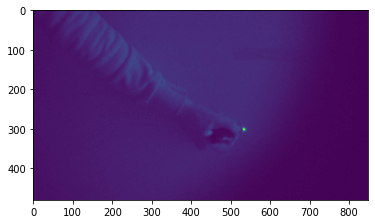

In [212]:
img = cv2.imread(PATH_DRAW + '0024.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img)

In [398]:
images_draw = []
images_hover = []
for path in DRAW_PATHS:
    images, _ = read_images(path)
    images_draw += images
    
for path in HOVER_PATHS:
    images, _ = read_images(path)
    images_hover += images 

images_draw = data_augmentation(images_draw)
images_hover = data_augmentation(images_hover)
images = images_draw + images_hover
labels = [0] * len(images_draw) + [1] * len(images_hover)

/tmp/ipykernel_222420/1043679742.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

In [410]:
images_draw, _ = read_images(PATH_DRAW_NEW)
images_hover, _ = read_images(PATH_HOVER_NEW)
#images_hover_close, _ = read_images(PATH_HOVER_CLOSE)
#images_hover_far, _ = read_images(PATH_HOVER_FAR)
#images_hover += images_hover_close
#images_hover += images_hover_far

images_draw = data_augmentation(images_draw)
images_hover = data_augmentation(images_hover)
images = images_draw + images_hover
labels = [0] * len(images_draw) + [1] * len(images_hover)

/tmp/ipykernel_222420/1043679742.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/756 [00:00<?, ?it/s]

In [411]:
train_X = np.array(images)
train_Y = np.array(labels)

print('Training data shape : ', train_X.shape, train_Y.shape)

Training data shape :  (10416, 48, 48) (10416,)


In [412]:
#Preprocessing for the Conv2D Layer for digits between 0 and 1
#train_X_shaped = train_X.reshape(-1, 24,24, 1)
#test_X_shaped = test_X.reshape(-1, 36,36, 1)
train_X = train_X.astype('float32')
train_X = train_X / 255.

In [413]:
train_Y_one_hot = to_categorical(train_Y)

In [414]:
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

train_X = train_X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(8332, 48, 48, 1) (2084, 48, 48) (8332, 2) (2084, 2)


In [415]:
unique, counts = np.unique(valid_label, return_counts=True)
dict(zip(unique, counts))

{0.0: 2084, 1.0: 2084}

## Batch Size

tried 4 -- 64, does not make a big difference

## Activation Function

relu is 3% better than linear, sigmoid, tanh

## Number of Dense Layers

3 and 5 are good

## Number of Neurons per Dense Layer

16 -- 256 makes almost no difference, but 128 is slightly better

## Number of Convolution Layers (1st param decreasing, kernel size increasing)

1 -- 3 is good, but almost no difference

## Epochs

more than one is fine

In [416]:
#Settings

batch_size = 32
epochs = 3
num_classes = 2
activation = 'relu'
layer_count = 3
num_neurons = 128

#for epochs in range(1, 7):
    #print(f'+++++ EPOCHS: {epochs} +++++')
#Define model structure
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=(IMG_SIZE,IMG_SIZE,1),padding='same'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(32, (5, 5), activation='linear',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(16, (7, 7), activation='linear',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))                 
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

# trial and error: linear performs much better than ReLU and sigmoid
for i in range(layer_count):
    model.add(Dense(num_neurons, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(128, activation='linear'))
#model.add(Dense(128, activation='linear'))

# classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

history = model.fit(
    train_X, 
    train_label, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

Epoch 1/3
261/261 [==============================] - 25s 95ms/step - loss: 0.3623 - accuracy: 0.8350 - val_loss: 0.2744 - val_accuracy: 0.8820
Epoch 2/3
261/261 [==============================] - 28s 106ms/step - loss: 0.1856 - accuracy: 0.9246 - val_loss: 0.0866 - val_accuracy: 0.9631
Epoch 3/3
261/261 [==============================] - 27s 102ms/step - loss: 0.0939 - accuracy: 0.9624 - val_loss: 0.0819 - val_accuracy: 0.9698


In [417]:
model.save('hover_predictor_binary_4')

INFO:tensorflow:Assets written to: hover_predictor_binary_4/assets


INFO:tensorflow:Assets written to: hover_predictor_binary_4/assets


In [366]:
test_images_draw, _ = read_images(PATH_TEST_DRAW)
test_images_hover, _ = read_images(PATH_TEST_HOVER)
test_images = test_images_draw + test_images_hover
print(len(test_images))

/tmp/ipykernel_222420/1043679742.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

302


In [407]:
predictions_draw = []
predictions_hover = []
confidences_draw = []
confidences_hover = []

for i in test_images_draw:
    img = i.astype('float32') / 255
    img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    predictions_draw.append(np.argmax(prediction))
    confidences_draw.append(prediction[0][0])
    
for i in test_images_hover:
    img = i.astype('float32') / 255
    img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    predictions_hover.append(np.argmax(prediction))
    confidences_hover.append(prediction[0][1])

In [408]:
print(1 - np.mean(predictions_draw), np.mean(confidences_draw))
print(np.mean(predictions_hover), np.mean(confidences_hover))

0.0 8.564023e-19
1.0 1.0


In [355]:
def predict(img):
    img = img.astype('float32') / 255
    img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    return prediction

hover
[[2.3264135e-04 9.9976736e-01]]


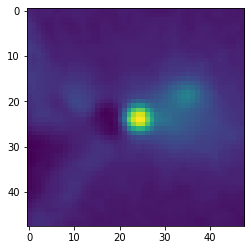

In [363]:
idx = random.randint(0, len(test_images) - 1)
test_image = test_images[idx]
#print(test_image)
if idx > len(test_images_draw):
    print('hover')
else:
    print('draw')
print(predict(test_image))
plt.imshow(test_image)

In [323]:
WRITE_PATH = '../out/write'
test_images_write, coords = read_images(WRITE_PATH)

/tmp/ipykernel_222420/1043679742.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/395 [00:00<?, ?it/s]

In [265]:
coords = np.array(coords)

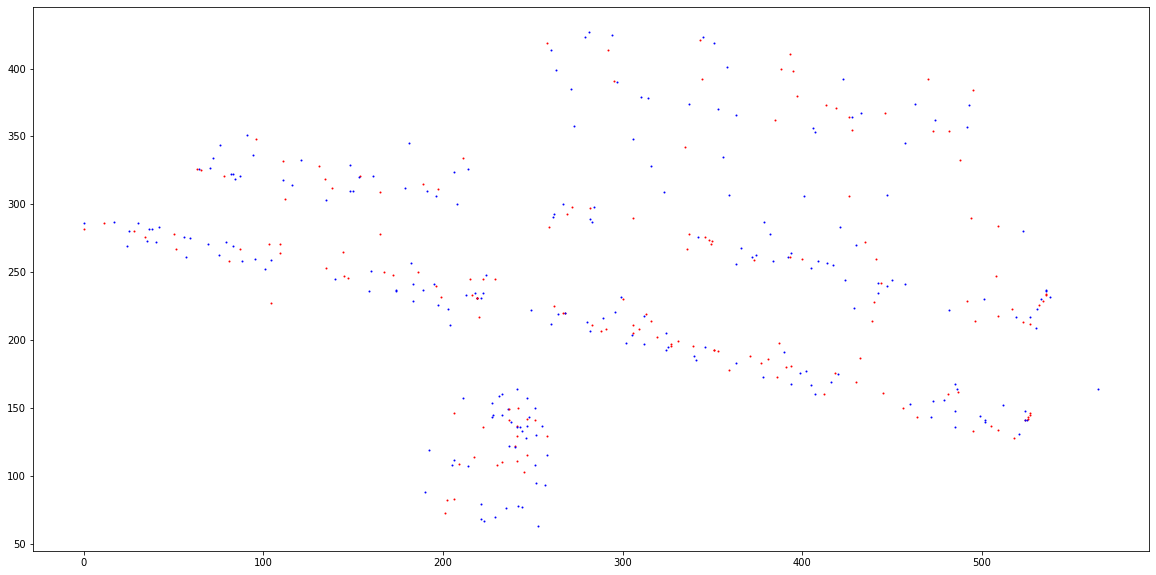

In [357]:
plt.figure(figsize = (20, 10))
for i in range(1, len(test_images_write)):
    pred = np.argmax(predict(test_images_write[i]))
    
    color = 'red' if pred == 1 else 'blue'
    plt.scatter(coords[i][0], coords[i][1], s=1, c=color)
    #plt.plot((coords[i-1][0], coords[i][0]), (coords[i-1][1], coords[i][1]), c=color)
#plt.scatter(coords.T[0], coords.T[1], s=1, c=color)

[[9.991322e-01 8.678388e-04]]


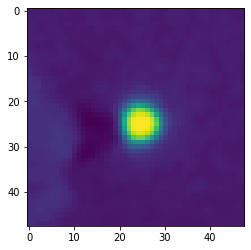

In [333]:
idx = random.randint(0, len(test_images_write) - 1)
test_image = test_images_write[idx]
#print(test_image)

print(predict(test_image))
plt.imshow(test_image)

draw
[[0.84201366 0.15798642]]


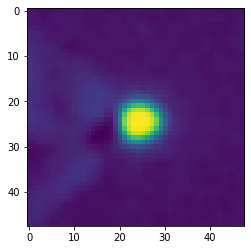

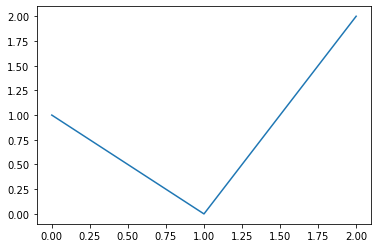

In [347]:
plt.plot((0,1, 2), (1,0, 2))